# UVA SDS CAPSTONE

## EXTERNAL FETAL MONITORING; CLASSIFICATION OF FHR/UC PATTERNS

## Stephanie Verbout, Landon BLakey, Shashank Sharma, Hayley Kisiel

#### 28 April 2022

In [1]:
# library imports
import os
import glob
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.datasets import load_files 
from keras.utils import np_utils
from tensorflow import keras
from keras.preprocessing import image
from tensorflow.keras import layers
import numpy as np

#!pip install tqdm
from tqdm import tqdm # progress bar


In [2]:
# Resets notebook state
tf.keras.backend.clear_session()

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print(
    "GPU is",
    "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.8.0
Eager mode:  True
GPU is available


In [3]:
# set seeds for reproducibility
np.random.seed(142) # note that you must use the same seed to ensure consistentcy in your training/validation/testing
tf.random.set_seed(142)

In [4]:
# set up image directory and sizes
data_dir = "../common/images/"

In [5]:
batch_size = 32;
# IMPORTANT: Depends on what pre-trained model you choose, you will need to change these dimensions accordingly
img_height = 299; 
img_width = 299;
class_names = ['ACC','DEC_EARLY','DEC_LATE','DEC_VAR','NONE']

# Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='int',
    class_names=class_names,
    validation_split = 0.35,
    subset = "training",
    seed = 142,
    image_size= (img_height, img_width),
    batch_size = batch_size
)

# Validation Dataset
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='int',
    class_names=class_names,
    validation_split = 0.35,
    subset = "validation",
    seed = 142,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 2398 files belonging to 5 classes.
Using 1559 files for training.
Found 2398 files belonging to 5 classes.
Using 839 files for validation.


2022-05-11 12:48:37.316238: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-11 12:48:39.171201: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38397 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:90:00.0, compute capability: 8.0


In [6]:
# verify correct class names
train_ds.class_names

['ACC', 'DEC_EARLY', 'DEC_LATE', 'DEC_VAR', 'NONE']

In [7]:
# split validation data into a validation and test dataset
mod = 5
val_batches = tf.data.experimental.cardinality(validation_ds)
test_dataset = validation_ds.take(val_batches // mod)
validation_dataset = validation_ds.skip(val_batches // mod)

print('Number of validation_ds (val_batches) batches (validation batches + test batches): %d' % val_batches)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of validation files: %d' % (tf.data.experimental.cardinality(validation_dataset)*val_batches))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))
print('Number of test files: %d' % (tf.data.experimental.cardinality(test_dataset)*val_batches)) 

Number of validation_ds (val_batches) batches (validation batches + test batches): 27
Number of validation batches: 22
Number of validation files: 594
Number of test batches: 5
Number of test files: 135


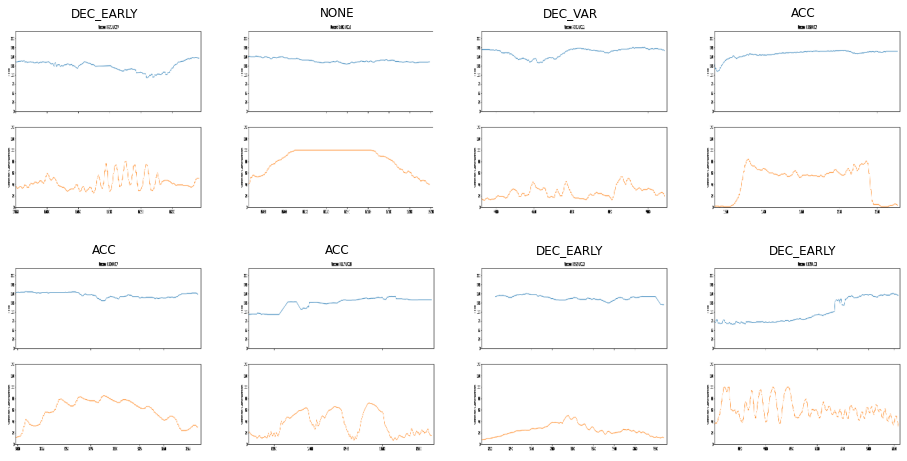

In [8]:
# display some example images
class_names = ['ACC','DEC_EARLY','DEC_LATE','DEC_VAR','NONE']

NUM_CLASSES = len(class_names)

# Rows and columns are set to fit one training batch (32)
n_rows = 2
n_cols = 4
plt.figure(figsize=(n_cols * 4, n_rows * 4))
for images, labels in train_ds.take(1):
    for i in range (n_rows*n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(class_names[labels[i]], fontsize=12)
plt.subplots_adjust(wspace=.2, hspace=.2)

In [9]:
# define a function to determine the number of each classification before splitting data
def get_class_counts(data):
    
    count_list = []
    for label_type in class_names:
        img_count = len(list(glob.glob(f"../common/images/{label_type}/record_*.png", recursive=True)))
        # append count to a list
        count_list.append(img_count)
    return count_list    # return the number of files for each class

In [10]:
get_class_counts(train_ds)

[523, 849, 170, 116, 740]

In [11]:
# verify class names
class_names

['ACC', 'DEC_EARLY', 'DEC_LATE', 'DEC_VAR', 'NONE']

In [12]:
# extract labels for each dataset
train_label = np.concatenate([y for x, y in train_ds], axis=0)
val_label = np.concatenate([y for x,y in validation_dataset], axis=0)
test_label = np.concatenate([y for x, y in test_dataset], axis=0)

In [13]:
# count instances of each class in each dataset
count_train = np.bincount(train_label).tolist()
count_val = np.bincount(val_label).tolist()
count_test = np.bincount(test_label).tolist()

In [14]:
# function to plot the distribution of each dataset
def plot_distributions(x_data, y_data, title, ylimit, color):
    # the freq of the data
    plt.rcParams["figure.figsize"] = (10,5)
    df = pd.DataFrame({'x_data':x_data,'y_data':y_data})
    df.sort_values('y_data', inplace=True)
    
    df.plot(kind='bar', y='y_data', x='x_data', color=color)
    plt.legend('')    #shows no legend
    plt.xlabel('Classification')
    plt.xticks(rotation = 45)
    plt.ylabel('Frequency')
    plt.title(title)
    plt.ylim(0, ylimit)
    
    plt.show()

In [15]:
#plot_distributions(class_names,count_train,'Frequency of Each Class: Training Data', 600, 'r')

In [16]:
#plot_distributions(class_names,count_val,'Frequency of Each Class: Validation Data', 280, 'g')

In [17]:
#plot_distributions(class_names,count_test,'Frequency of Each Class: Test Data', 65, 'b')

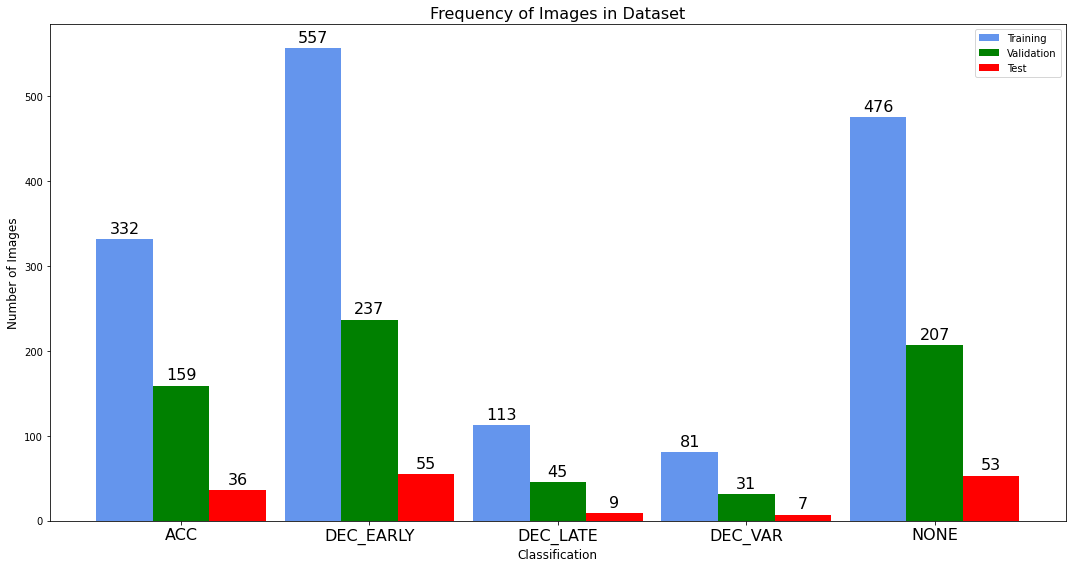

In [18]:
# plot dataset distributions
X_axis = np.arange(len(class_names))
plot_labels = ['ACC', 'DEC_EARLY', 'DEC_LATE', 'DEC_VAR', 'NONE']
width = 0.3  # width of the bars

plt.rcParams["figure.figsize"] = (15,8)
fig, ax = plt.subplots()
rects1 = ax.bar(X_axis-width, count_train, 0.3, label = 'Training', color='cornflowerblue')
rects2 = ax.bar(X_axis, count_val, 0.3, label = 'Validation', color='g')
rects3 = ax.bar(X_axis+width, count_test, 0.3, label = 'Test', color='r')

# Add some text for labels, title and custom x-axis tick labels
ax.set_xticks(X_axis)
ax.set_xticklabels(plot_labels, fontsize=16)
ax.set_xlabel("Classification", fontsize=12)
ax.set_ylabel("Number of Images", fontsize=12)
ax.set_title("Frequency of Images in Dataset", fontsize=16)
ax.legend()
# show the numbers for each bar
ax.bar_label(rects1, padding=3, fontsize=16)
ax.bar_label(rects2, padding=3, fontsize=16)
ax.bar_label(rects3, padding=3, fontsize=16)

fig.tight_layout()

plt.show()

In [19]:
# define function to plot the accuracies of train and validation set
def plot_hist(hist):
    plt.plot(hist.history["sparse_categorical_accuracy"])
    plt.plot(hist.history["val_sparse_categorical_accuracy"])
    plt.title("Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.ylim(0.0,1.0)
    plt.show()

In [20]:
# Resets notebook state
tf.keras.backend.clear_session()

In [21]:
# build model function

def build_model(trainable_layers=15):

    #for layer in model.layers[ :-trainable_layers]:
    #    layer.trainable = False
    #for layer in model.layers[-trainable_layers: ]:
    #    layer.trainable = True

    model = keras.models.Sequential([
            keras.layers.InputLayer(input_shape=[299,299,3],   # our input_shape=[299, 299, 3]
                                    dtype='float32',
                                    input_tensor=None,
                                    sparse=False,
                                    name='input_1',
                                    ragged=None,
                                    type_spec=None),
            keras.layers.Conv2D(filters=4,                        # batch_input_shape = [1, 2, 1800]
                                kernel_size=(1,30),
                                strides=(1, 1),
                                padding='same',
                                data_format='channels_last',
                                dilation_rate=(1, 1),
                                groups=1,
                                activation='linear',
                                use_bias=False,
                                kernel_initializer='he_normal',
                                bias_initializer='zeros',
                                kernel_regularizer=None,
                                bias_regularizer=None,
                                activity_regularizer=None,
                                kernel_constraint=None,
                                bias_constraint=None,
                                trainable=True,
                                name='conv2d'),
            keras.layers.BatchNormalization(axis=3,
                                            momentum=0.99,
                                            epsilon=0.001,
                                            center=True,scale=True,
                                            trainable=True,
                                            name='batch_normalization'),
            keras.layers.DepthwiseConv2D(kernel_size = (2, 1),
                                         strides=(1, 1),
                                         padding='valid',
                                         depth_multiplier=2,
                                         data_format='channels_last',
                                         dilation_rate=(1, 1),
                                         activation='linear',
                                         use_bias=False,
                                         depthwise_initializer='he_normal',
                                         bias_initializer='zeros',
                                         depthwise_regularizer=None,
                                         bias_regularizer=None,
                                         activity_regularizer=None,
                                         depthwise_constraint="MaxNorm",
                                         bias_constraint=None,
                                         trainable=True,
                                         name='depthwise_conv2d'),
            keras.layers.BatchNormalization(axis=3,
                                            momentum=0.99,
                                            epsilon=0.001,
                                            center=True,
                                            scale=True,
                                            trainable=True,
                                            name='batch_normalization_1'),
            keras.layers.Activation('elu', 
                                    trainable=True, 
                                    name='activation'),
            keras.layers.MaxPooling2D(pool_size=(1,4), 
                                      strides=(1,4), 
                                      padding='valid', 
                                      data_format='channels_last',
                                      trainable=True,
                                      name='max_pooling2d'),
            keras.layers.Dropout(0.50, 
                                 trainable=True, 
                                 name='dropout'),
            keras.layers.SeparableConv2D(filters=8,
                                         kernel_size=(1,7),
                                         strides=(1, 1),
                                         padding='same',
                                         data_format='channels_last',
                                         dilation_rate=(1, 1),
                                         depth_multiplier=1,
                                         activation='linear',
                                         use_bias=False,
                                         depthwise_initializer='he_normal',
                                         pointwise_initializer='he_normal',
                                         bias_initializer='zeros',
                                         trainable=True,
                                         name='separable_conv2d'),
            keras.layers.BatchNormalization(axis=3,
                                            momentum=0.99,
                                            epsilon=0.001,
                                            center=True,
                                            scale=True,
                                            trainable=True,
                                            name='batch_normalization_2'),
            keras.layers.Activation('elu', 
                                    trainable=True, 
                                    name='activation_1'),
            keras.layers.MaxPooling2D(pool_size=(1,4), 
                                      strides=(1,4), 
                                      padding='valid', 
                                      data_format='channels_last',
                                      trainable=True,
                                      name='max_pooling2d_1'),
            keras.layers.Dropout(0.50, 
                                 trainable=True, 
                                 name='dropout_1'),
            keras.layers.Flatten(data_format='channels_last', 
                                 trainable=True, 
                                 name='flatten'),
            keras.layers.Dense(units=NUM_CLASSES*150,
                               activation='linear',
                               use_bias=True,
                               kernel_initializer='he_normal',
                               bias_initializer='zeros',
                               kernel_regularizer=tf.keras.regularizers.l2(0.01),
                               bias_regularizer=None,
                               activity_regularizer=None,
                               kernel_constraint='MaxNorm',
                               trainable=True,
                               name='dense1'),
            keras.layers.Dense(units=NUM_CLASSES*75,
                               activation='linear',
                               use_bias=True,
                               kernel_initializer='he_normal',
                               bias_initializer='zeros',
                               kernel_regularizer=tf.keras.regularizers.l2(0.01),
                               bias_regularizer=None,
                               activity_regularizer=None,
                               kernel_constraint='MaxNorm',
                               trainable=True,
                               name='dense2'),
            keras.layers.Dense(units=NUM_CLASSES,
                               activation='softmax',
                               trainable=True,
                               name='softmax_output') # softmax for 5 class output
            ], 
        
            name = "AdaptedCTGNet")    # model name

    optimizer = keras.optimizers.Adam(learning_rate=1e-5, decay=1e-3)
    # use sparse_categorical_crossentropy as labels are not one-hot encoded
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=['sparse_categorical_accuracy'])

    print(model.summary())
    
    return model

In [22]:
# build the Adapted CTGNet model with function above
model = build_model()
model

Model: "AdaptedCTGNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 299, 299, 4)       360       
                                                                 
 batch_normalization (BatchN  (None, 299, 299, 4)      16        
 ormalization)                                                   
                                                                 
 depthwise_conv2d (Depthwise  (None, 298, 299, 8)      16        
 Conv2D)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 298, 299, 8)      32        
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 298, 299, 8)       0         
                                                     

Epoch 1/100


2022-05-11 12:48:45.858282: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2022-05-11 12:48:50.692501: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


49/49 [==============================] - 17s 171ms/step - loss: 27.0449 - sparse_categorical_accuracy: 0.3143 - val_loss: 26.8805 - val_sparse_categorical_accuracy: 0.3608
Epoch 2/100
49/49 [==============================] - 8s 162ms/step - loss: 26.1171 - sparse_categorical_accuracy: 0.3637 - val_loss: 24.0483 - val_sparse_categorical_accuracy: 0.4404
Epoch 3/100
49/49 [==============================] - 8s 164ms/step - loss: 25.8865 - sparse_categorical_accuracy: 0.3784 - val_loss: 23.8616 - val_sparse_categorical_accuracy: 0.4477
Epoch 4/100
49/49 [==============================] - 8s 160ms/step - loss: 25.6788 - sparse_categorical_accuracy: 0.3881 - val_loss: 24.7051 - val_sparse_categorical_accuracy: 0.3726
Epoch 5/100
49/49 [==============================] - 8s 165ms/step - loss: 25.5438 - sparse_categorical_accuracy: 0.4041 - val_loss: 24.3629 - val_sparse_categorical_accuracy: 0.4124
Epoch 6/100
49/49 [==============================] - 8s 161ms/step - loss: 25.3907 - sparse_cate

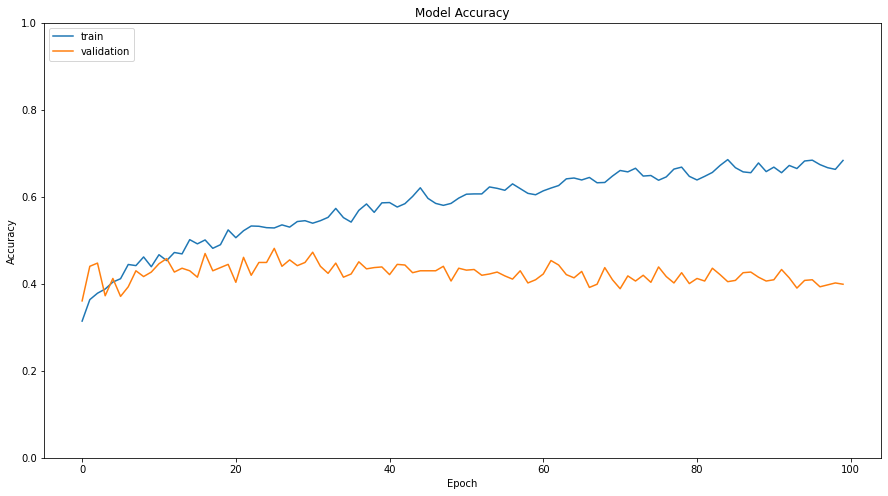

In [23]:
# fit the model to image data and train
history = model.fit(train_ds,
                    epochs=100,
                    validation_data=validation_dataset,
                    batch_size = batch_size,
                    callbacks = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=7)
                    )
# plot the accuracies and epochs
plot_hist(history)

In [24]:
# evaluate model on test_dataset
model.evaluate(test_dataset)

5/5 [==============================] - 0s 19ms/step - loss: 22.1475 - sparse_categorical_accuracy: 0.4563


[22.147451400756836, 0.45625001192092896]

In [25]:
# save model
model.save('CTG_model_final')

2022-05-11 13:02:26.228063: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: CTG_model_final/assets


In [26]:
# extract accuracy and loss data from training
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

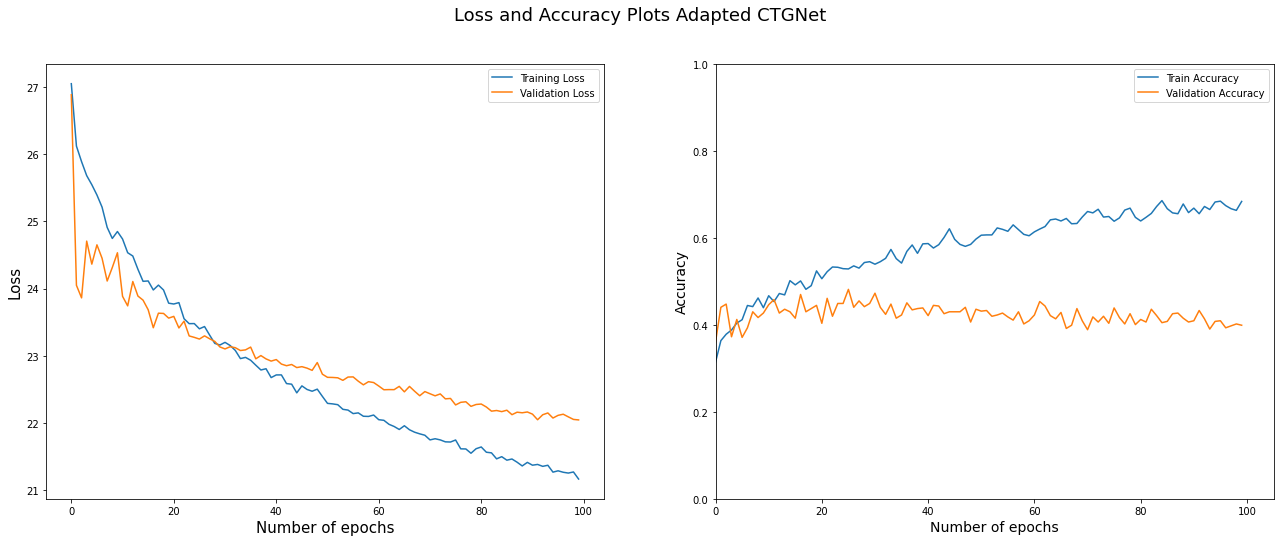

In [27]:
# plot the accuracy and loss
plt.figure(figsize=(22,8))

plt.suptitle('Loss and Accuracy Plots Adapted CTGNet', fontsize=18)

plt.subplot(1,2,1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.xlabel('Number of epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)

plt.subplot(1,2,2)
plt.plot(acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.xlabel('Number of epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xlim(0,105)
plt.ylim(0,1)
plt.show()

In [28]:
# see labels in test_dataset
#for image, label in test_dataset.take(5):
#    print (label)

## CONFUSION MATRIX

In [29]:
# unbatch to get all of test set
all_testing_data = test_dataset.unbatch()

In [30]:
# extract all test data and labels to lists
data_list =[]
label_list =[]
for x, y in all_testing_data:
    data_list.append(x)
    label_list.append(y)

In [31]:
# make predictions on test set using model
predictions = model.predict(np.array(data_list))
# save highest class prediction into array
y_pred= np.argmax(predictions, axis=1)
# save the label_list as the true response labels
y_true = np.array(label_list)

In [32]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

# print classification report from sklearn
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

         ACC       0.39      0.55      0.45        31
   DEC_EARLY       0.68      0.53      0.60        53
    DEC_LATE       0.22      0.15      0.18        13
     DEC_VAR       0.10      0.14      0.12         7
        NONE       0.55      0.55      0.55        56

    accuracy                           0.49       160
   macro avg       0.39      0.39      0.38       160
weighted avg       0.52      0.49      0.50       160



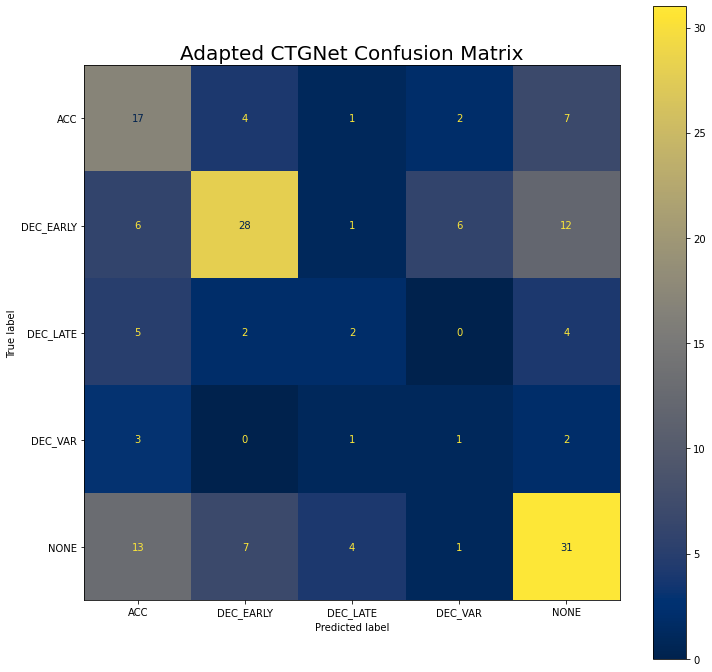

In [33]:
# plot the confusion matrix
fig, ax = plt.subplots(figsize=(12,12))
ax.set_title("Adapted CTGNet Confusion Matrix", fontsize = 20)
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=class_names, cmap='cividis', ax=ax)

## Adapted CTGNet ROC Curves

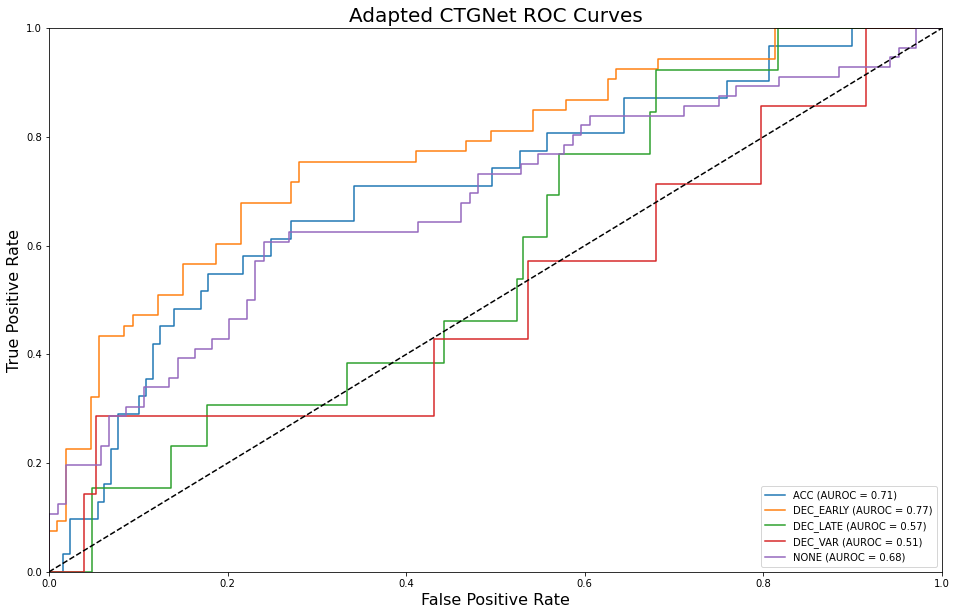

In [34]:
y_true = label_binarize(y_true, classes=[0,1,2,3,4])
n_classes = y_true.shape[1]
y_score = predictions

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# convert the dictionary keys into more readable format for nicer legend
convert_to_names = {0:'ACC', 1:'DEC_EARLY', 2:'DEC_LATE', 3:'DEC_VAR', 4:'NONE'}
fpr = {convert_to_names[k]:fpr[k] for k in fpr}
tpr = {convert_to_names[k]:tpr[k] for k in tpr}
roc_auc = {convert_to_names[k]:roc_auc[k] for k in roc_auc}

# Plot ROC curve
plt.figure(figsize=(16,10))

for i in roc_auc.keys():
    plt.plot(fpr[i], tpr[i], label='{0} (AUROC = {1:0.2f})'''.format(i, roc_auc[i]))


plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Adapted CTGNet ROC Curves', fontsize=20)
plt.legend(loc="lower right")
plt.show()

# Now apply transfer learning with EfficientNetB3

In [35]:
# now apply transfer learning
def build_model_transfer(model_base, img_size=None, trainable_layers=15):

    for layer in model_base.layers[ :-trainable_layers]:
      layer.trainable = False
    for layer in model_base.layers[-trainable_layers: ]:
      layer.trainable = True
    
    
    model = keras.Sequential()
    model.add(keras.layers.Lambda(lambda image: tf.image.resize(image, (img_size, img_size))))
    # model.add(keras.layers.RandomFlip("horizontal"))
    # model.add(keras.layers.RandomRotation(0.1))
    # model.add(keras.layers.Rescaling(scale=1 / 127.5, offset=-1))
    model.add(model_base)
    model.add(keras.layers.GlobalAveragePooling2D())
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(1024, activation='elu'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(NUM_CLASSES, activation="softmax"))

    optimizer = keras.optimizers.Adam(learning_rate=1e-4, decay=1e-3)

    model.build(input_shape=(None,299,299,3))
    # use sparse_categorical_crossentropy as labels are not one-hot encoded
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    
    print(model.summary())
    
    return model

In [36]:
# create base EfficientNet model with ImageNet images
base_model1 = tf.keras.applications.EfficientNetB3(include_top=False, input_shape=(299,299,3), weights="imagenet")

# build the model
model_1 = build_model_transfer(base_model1, img_size=299, trainable_layers=118)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 299, 299, 3)       0         
                                                                 
 efficientnetb3 (Functional)  (None, 10, 10, 1536)     10783535  
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1536)             6144      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 1024)              1

In [37]:
#base_model1.summary()

In [38]:
# fit the model to training data and validation data
history_eff = model_1.fit(train_ds,
                      epochs=80,
                      validation_data = validation_dataset,
                      batch_size = batch_size,
                      callbacks = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=7)
                      )

Epoch 1/80
49/49 [==============================] - 16s 147ms/step - loss: 2.5750 - accuracy: 0.2412 - val_loss: 1.5755 - val_accuracy: 0.2577
Epoch 2/80
49/49 [==============================] - 5s 98ms/step - loss: 2.1721 - accuracy: 0.3361 - val_loss: 1.4661 - val_accuracy: 0.4124
Epoch 3/80
49/49 [==============================] - 5s 99ms/step - loss: 1.9960 - accuracy: 0.3913 - val_loss: 1.4114 - val_accuracy: 0.4065
Epoch 4/80
49/49 [==============================] - 5s 97ms/step - loss: 1.8070 - accuracy: 0.4529 - val_loss: 1.3757 - val_accuracy: 0.4404
Epoch 5/80
49/49 [==============================] - 5s 97ms/step - loss: 1.5976 - accuracy: 0.4952 - val_loss: 1.3438 - val_accuracy: 0.4757
Epoch 6/80
49/49 [==============================] - 5s 100ms/step - loss: 1.5296 - accuracy: 0.5138 - val_loss: 1.3953 - val_accuracy: 0.4860
Epoch 7/80
49/49 [==============================] - 5s 97ms/step - loss: 1.4121 - accuracy: 0.5401 - val_loss: 1.5037 - val_accuracy: 0.4890
Epoch 8/80

In [39]:
# extract accuracy and loss data from training
acc_eff = history_eff.history['accuracy']
val_acc_eff = history_eff.history['val_accuracy']

loss_eff = history_eff.history['loss']
val_loss_eff = history_eff.history['val_loss']

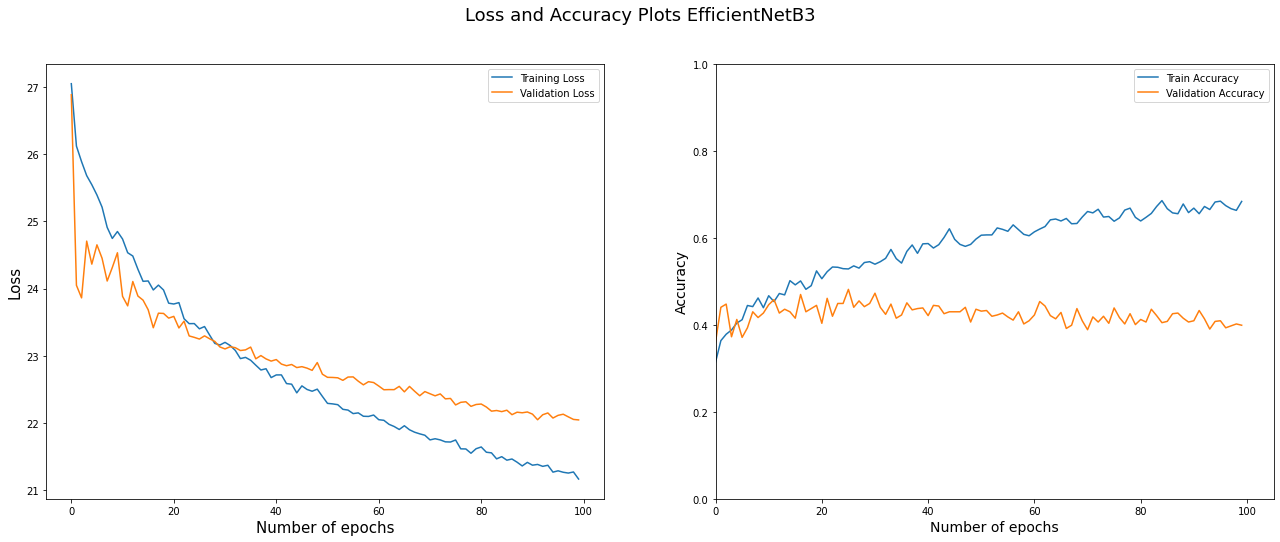

In [40]:
# plot the accuracy and loss
plt.figure(figsize=(22,8))

plt.suptitle('Loss and Accuracy Plots EfficientNetB3', fontsize=18)

plt.subplot(1,2,1)
plt.plot(loss_eff, label='Training Loss')
plt.plot(val_loss_eff, label='Validation Loss')
plt.legend()
plt.xlabel('Number of epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)

plt.subplot(1,2,2)
plt.plot(acc_eff, label='Train Accuracy')
plt.plot(val_acc_eff, label='Validation Accuracy')
plt.legend()
plt.xlabel('Number of epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xlim(0,105)
plt.ylim(0,1)
plt.show()

In [41]:
# evaluate model on test_dataset
model_1.evaluate(test_dataset)

5/5 [==============================] - 0s 51ms/step - loss: 4.2719 - accuracy: 0.4000


[4.271914482116699, 0.4000000059604645]

In [42]:
# save model
model_1.save('CTG_model_final_EFF')

INFO:tensorflow:Assets written to: CTG_model_final_EFF/assets


## EfficientNetB3 Confusion Matrix

In [43]:
# unbatch to get all of test set
all_testing_data = test_dataset.unbatch()

In [44]:
# extract all test data and labels to lists
data_list_1 =[]
label_list_1 =[]
for x, y in all_testing_data:
    data_list_1.append(x)
    label_list_1.append(y)

In [45]:
# make predictions on test set using model
predictions_1 = model_1.predict(np.array(data_list_1))
# save highest class prediction into array
y_pred_1= np.argmax(predictions_1, axis=1)
# save the label_list as the true response labels
y_true_1 = np.array(label_list_1)

In [46]:
# print classification report from sklearn
print(classification_report(y_true_1, y_pred_1, target_names=class_names))

              precision    recall  f1-score   support

         ACC       0.41      0.49      0.44        37
   DEC_EARLY       0.67      0.53      0.59        57
    DEC_LATE       0.23      0.33      0.27         9
     DEC_VAR       0.00      0.00      0.00         6
        NONE       0.45      0.45      0.45        51

    accuracy                           0.46       160
   macro avg       0.35      0.36      0.35       160
weighted avg       0.49      0.46      0.47       160



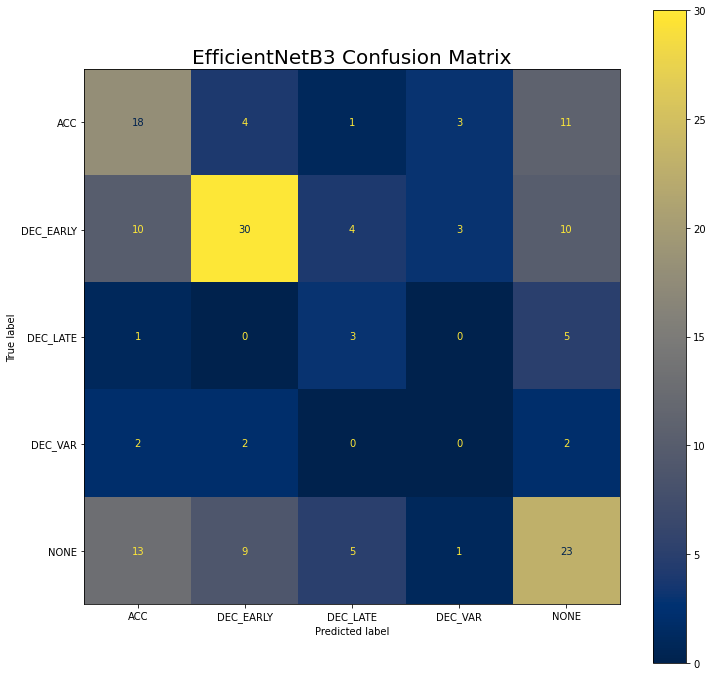

In [47]:
# plot the confusion matrix
fig, ax = plt.subplots(figsize=(12,12))
ax.set_title("EfficientNetB3 Confusion Matrix", fontsize = 20)
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_true_1, y_pred_1, display_labels=class_names, cmap='cividis', ax=ax)

## EfficientNetB3 ROC Curves

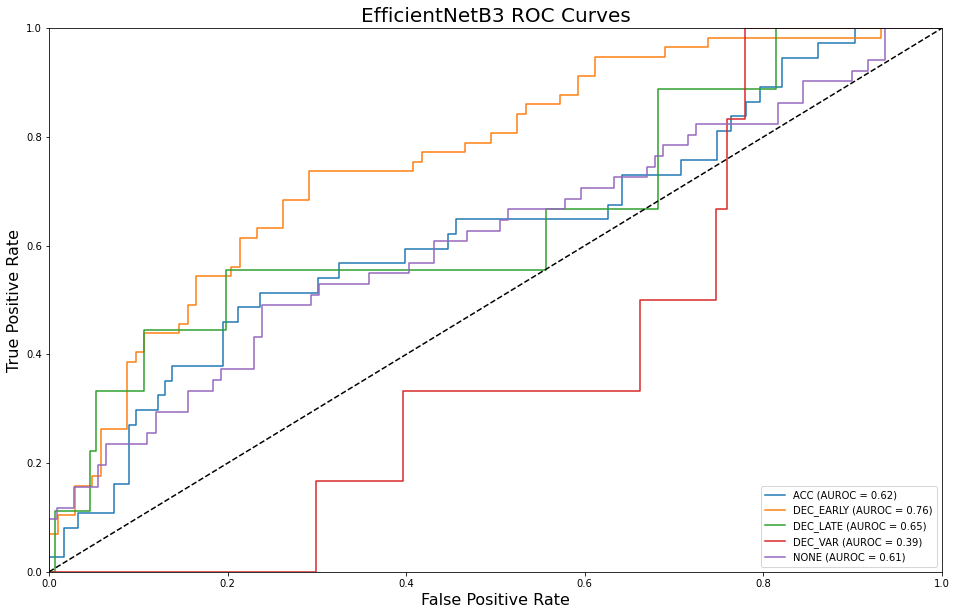

In [48]:
y_true_1 = label_binarize(y_true_1, classes=[0,1,2,3,4])
n_classes_1 = y_true_1.shape[1]
y_score_1 = predictions_1

# Compute ROC curve and ROC area for each class
fpr_1 = dict()
tpr_1 = dict()
roc_auc_1 = dict()
for i in range(n_classes_1):
    fpr_1[i], tpr_1[i], _ = roc_curve(y_true_1[:, i], y_score_1[:,i])
    roc_auc_1[i] = auc(fpr_1[i], tpr_1[i])
    
# convert the dictionary keys into more readable format for nicer legend
convert_to_names = {0:'ACC', 1:'DEC_EARLY', 2:'DEC_LATE', 3:'DEC_VAR', 4:'NONE'}
fpr_1 = {convert_to_names[k]:fpr_1[k] for k in fpr_1}
tpr_1 = {convert_to_names[k]:tpr_1[k] for k in tpr_1}
roc_auc_1 = {convert_to_names[k]:roc_auc_1[k] for k in roc_auc_1}

# Plot ROC curve
plt.figure(figsize=(16,10))

for i in roc_auc_1.keys():
    plt.plot(fpr_1[i], tpr_1[i], label='{0} (AUROC = {1:0.2f})'''.format(i, roc_auc_1[i]))


plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('EfficientNetB3 ROC Curves', fontsize=20)
plt.legend(loc="lower right")
plt.show()